In [1]:

## First, let’s implement the encoder net Q(z|X), 
## which takes input X and outputting two things: μ(X) and Σ(X), the parameters of the Gaussian.

from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:

# m : batch size
m = 50   
# n_z : latent dimension
n_z = 2
# n_epoch : number of epoches for iterations
n_epoch = 10

epsilon_std=1.0
# intermediate_dim = 512

# Q(z|X) -- encoder
inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)


In [3]:

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=epsilon_std)
    return mu + K.exp(log_sigma / 2) * eps


In [4]:
# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])

In [5]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In [6]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
generator = Model(d_in, d_out)

In [7]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [8]:
from keras.datasets import mnist
(x_train, _), (x_test, y_test) = mnist.load_data()


In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [10]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, batch_size=m, epochs=n_epoch)

Epoch 1/10
60000/60000 [==============================] - 7s 110us/step - loss: 491.0512
Epoch 2/10
60000/60000 [==============================] - 5s 82us/step - loss: 432.4473
Epoch 3/10
60000/60000 [==============================] - 5s 85us/step - loss: 431.2919
Epoch 4/10
60000/60000 [==============================] - 5s 81us/step - loss: 431.0615
Epoch 5/10
60000/60000 [==============================] - 6s 102us/step - loss: 431.0524
Epoch 6/10
60000/60000 [==============================] - 6s 97us/step - loss: 431.0501
Epoch 7/10
60000/60000 [==============================] - 5s 88us/step - loss: 431.0493
Epoch 8/10
60000/60000 [==============================] - 5s 88us/step - loss: 431.0488
Epoch 9/10
60000/60000 [==============================] - 5s 90us/step - loss: 431.0486
Epoch 10/10
60000/60000 [==============================] - 5s 90us/step - loss: 431.0484: 0s - lo


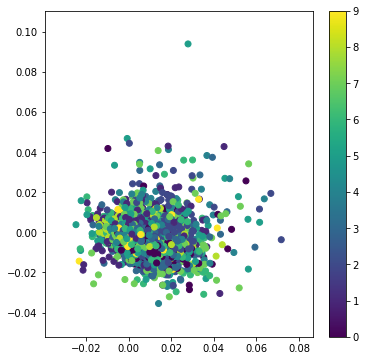

In [11]:
x_test_encoded = encoder.predict(x_test, batch_size=m)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

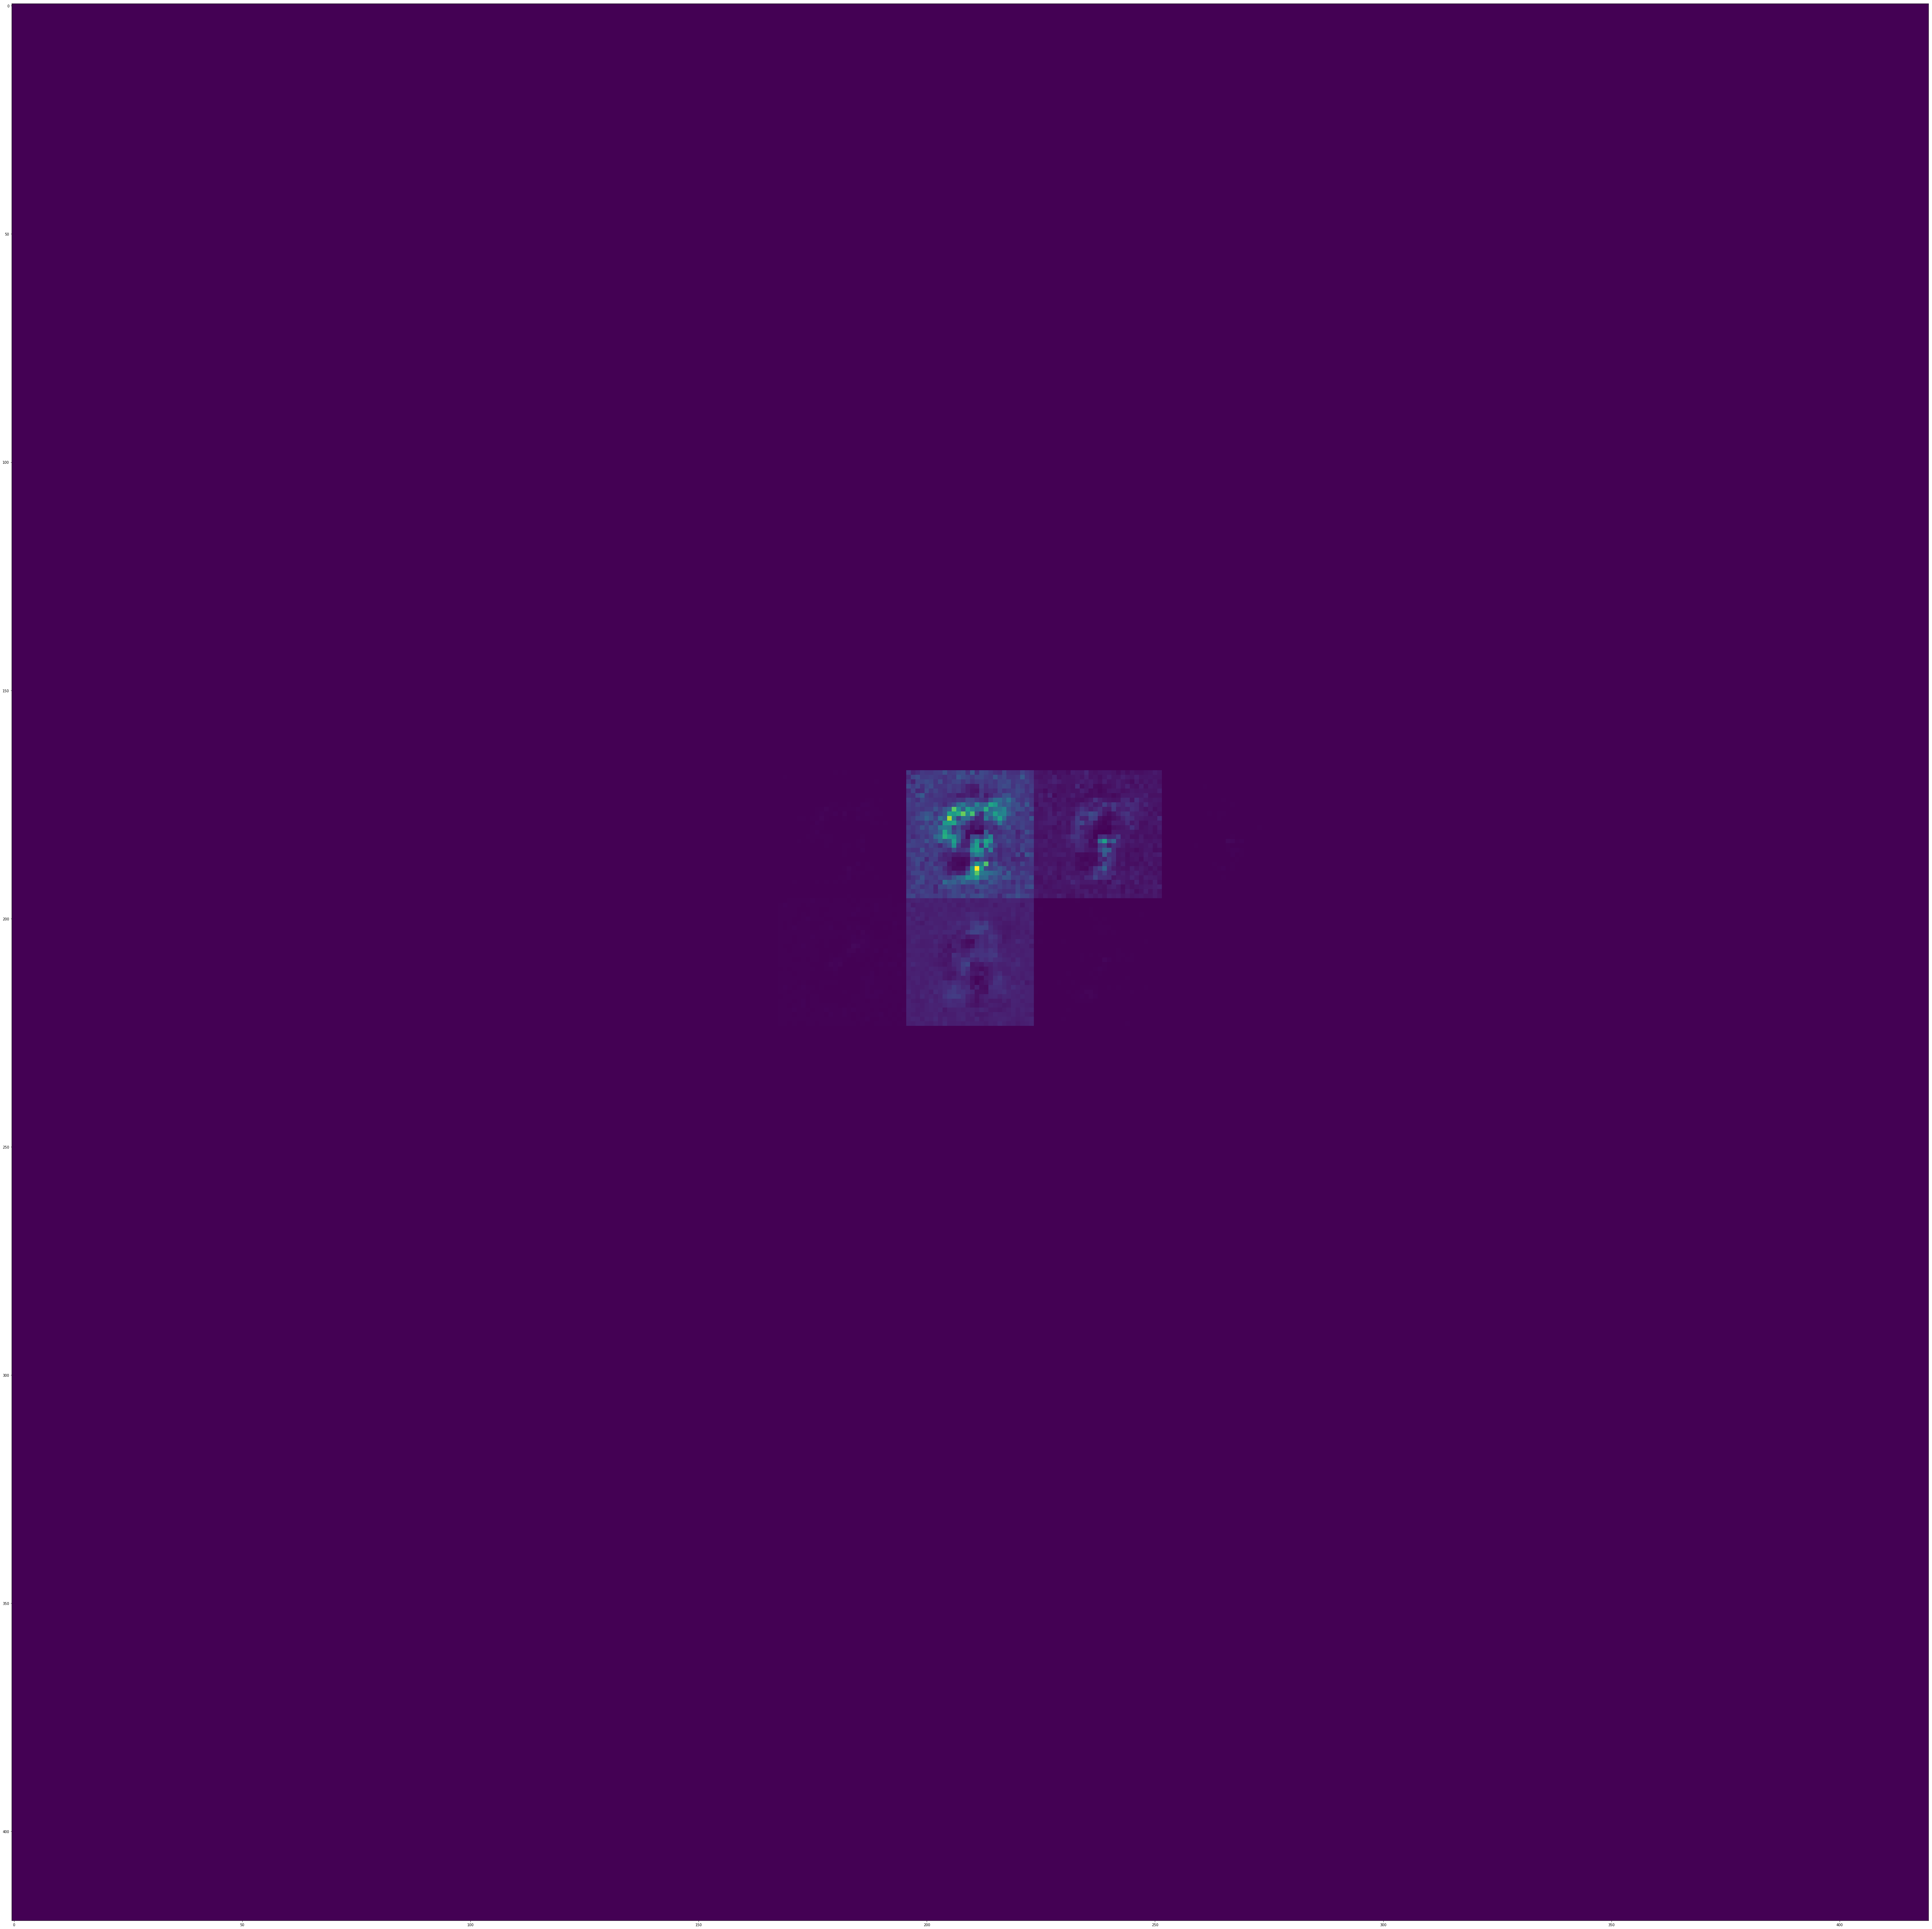

In [12]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 2.0
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(100, 100))
plt.imshow(figure)
plt.show()



In [ ]:
import time

start = time.time()

# Creates a graph.
with tf.device('/gpu:0'):
 a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
 b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
 c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.


end = time.time()
print(sess.run(c))
print(end - start)

In [ ]:
from tensorflow.python.client import device_lib

[device.name[8:] for device in device_lib.list_local_devices() ]